# Reddit Data Collection and Visualization

This notebook is designed to collect comments from a specified subreddit using Reddit's API through PRAW (Python Reddit API Wrapper). It filters out comments based on predefined blacklists and visualizes the data for insights.

## Features:
- Fetch comments from a chosen subreddit and filter ('top', 'hot', 'controversial').
- Exclude comments from blacklisted authors and comments with specific content (e.g., '[deleted]', '[removed]').
- Visualize the collected data for insights.

## Setup and Imports

Before running this notebook, ensure you have installed the necessary Python packages: `praw`, `pandas`, and any others required for your specific environment.


In [1]:
import praw
import pandas as pd

from datetime import datetime
from typing import TypedDict
import matplotlib.pyplot as plt

# PRAW core exceptions
import prawcore
from prawcore.exceptions import Redirect, RequestException

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Configuration

Set the target subreddit, and other configurations here.

In [2]:
# Subreddit configuration
SUBREDDIT_NAME = 'Philippines'
SUBREDDIT_FILTER = 'hot'    # 'hot', 'top', 'controversial'
LIMIT = 11  # Adjust as needed, up to a maximum of 1000 due to Reddit's API limit

# Data filtering criteria
AUTHOR_BLACKLIST = ['AutoModerator']
BODY_BLACKLIST = ['[deleted]', '[removed]']

# Define options for subreddit fetching, mainly the limit
OPTIONS = {
    'limit': LIMIT,
}

# Constants for file naming
CURRENT_DATETIME = datetime.today().strftime("%Y%m%d-%H%M%S")   # Current date and time for filename
FILENAME = f'data-{SUBREDDIT_NAME}-{CURRENT_DATETIME}-{SUBREDDIT_FILTER}.csv'  # Filename format

## DataRow Definition

Define a structure for the data rows to ensure consistent data handling. We make a type for better clarity of the shape of the data being printed to the CSV.

In [3]:
class DataRow(TypedDict):
    body: str
    submission_name: str
    submission_text: str

## Data Collection & Execution

In this section, we will execute the data collection process which involves connecting to the Reddit API through PRAW (Python Reddit API Wrapper), fetching comments from the specified subreddit, and filtering the data based on predefined criteria. The final dataset will then be prepared for analysis and saved to a CSV file for further use.


In [4]:
from dotenv import load_dotenv
import os

# Load the .env file for reddit secrets
# Make sure to copy the file '.env.example' to '.env'
# and fill up the information there
load_dotenv()

True

In [5]:
# Initialize PRAW Reddit instance with credentials & user agent
reddit = praw.Reddit(
    client_id=os.getenv('REDDIT_CLIENT_ID'),
    client_secret=os.getenv('REDDIT_CLIENT_SECRET'),
    user_agent=os.getenv('REDDIT_USER_AGENT'),
    ratelimit_seconds=6000, # Give heavy allowance for rate limits to avoid TooManyRequests error
)

data_collection: list[DataRow] = [] # List to hold all DataRow items

print(reddit)

In [6]:
# Get subreddit instance from PRAW
subreddit_instance = reddit.subreddit(SUBREDDIT_NAME)
subreddit_instance

Subreddit(display_name='Philippines')

In [7]:
# Select the subreddit section based on the filter argument (top, controversial, hot)
result = {
    'top': subreddit_instance.top(**OPTIONS),
    'controversial': subreddit_instance.controversial(**OPTIONS),
    'hot': subreddit_instance.hot(**OPTIONS),
}[SUBREDDIT_FILTER]

result

### Data Gathering Loop

In [8]:
from tqdm.auto import tqdm # Import tqdm for fancy progress bar

In [9]:
try:
    with tqdm(total=LIMIT, desc="POSTS") as progress_bar:
        for submission in result:   # Iterate through submissions in the selected subreddit section
            progress_bar.update(1)

            submission.comments.replace_more(limit=None)    # Load all comments by replacing "MoreComments"
            comments = submission.comments.list()   # Flatten the comment tree into a list

            for comment in tqdm(comments, desc="COMMENTS"):    # Iterate through each comment
                # Get author name, or set as empty string if not available
                author = (
                    comment.author.name 
                    if isinstance(comment.author, praw.models.Redditor) 
                    else ''
                )
                body = comment.body # Comment text
    
                # Skip comment if the author is in the blacklist
                if author in AUTHOR_BLACKLIST: continue
    
                # Skip comment if body is in the blacklist
                if body in BODY_BLACKLIST: continue
    
                data_row: DataRow = {
                    'submission_name': submission.title,
                    'submission_text': submission.selftext,
                    'body': body,
                }
                data_collection.append(data_row)    # Add the data row to the collection
except prawcore.exceptions.TooManyRequests:
    pass    # Handle rate limit exceptions gracefully
except Redirect:
    print("ERROR: Request redirected. Please check subreddit name and try again")
    exit(1)
except RequestException:
    print("ERROR: Request exception. Please check subreddit name and try again")
    exit(1)

print('Finished gathering data')

COMMENTS: 0it [00:00, ?it/s] [00:00<00:09,  1.00it/s]
POSTS: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]

Finished gathering data


### Save the data

In [10]:
# Convert the list of DataRow dictionaries to a Pandas DataFrame
data_frame = pd.DataFrame(data_collection)

data_frame.to_csv(FILENAME, index=False) # Save the DataFrame to a CSV file

print(f"Saved as {FILENAME}")

Saved as data-Philippines-20240208-133857-hot.csv


## Data Visualization

Visualize the collected data to gain insights, such as the number of comments per post.

In [11]:
# Show the table

data_frame.head()

,submission_name,submission_text,body
0,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,I want to start vlogging and I'm going to use ...
1,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi Po need lang Po nang Help kc Po. May Visa a...
2,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,"NBI HIT\nGot an incident pero suoer tagal, 24 ..."
3,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Hi! Hope somebody can help me with knowing wha...
4,"Weekly help thread - Feb 05, 2024",Need help on something? Whether it's about hea...,Planning to buy dumbbell and my last lift was ...


/opt/anaconda3/envs/Hate-Speech/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128075 (\N{WAVING HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/Hate-Speech/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


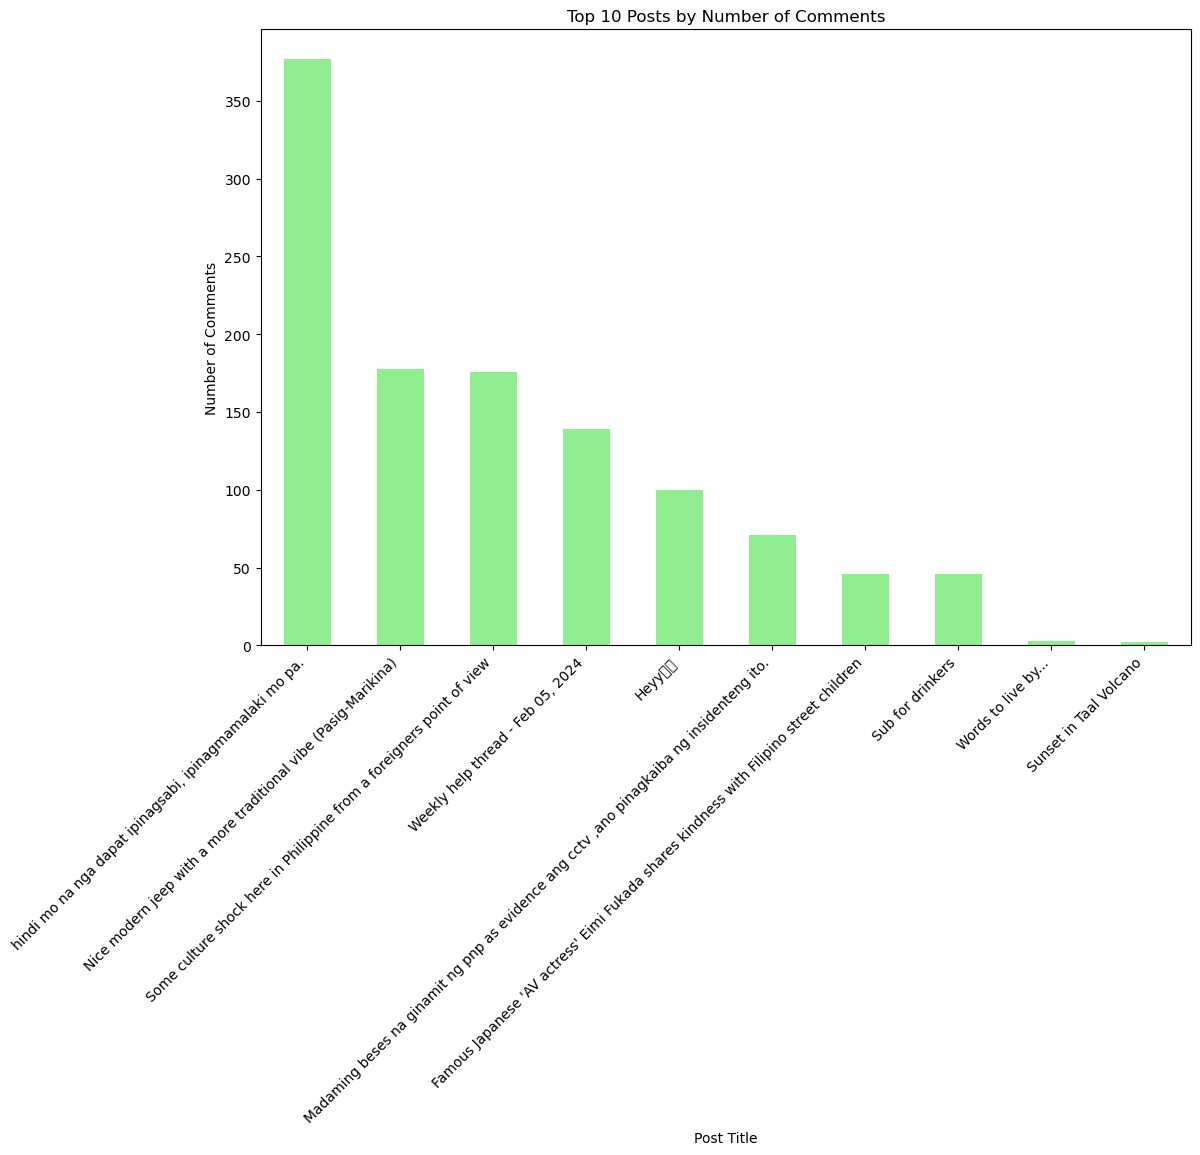

In [13]:
# Group the data by submission_name and count the number of comments for each post
# Use 'body' column for counting since every comment should have a body
comments_per_post = data_frame.groupby('submission_name')['body'].count()

# Sorting the counts and selecting the top N posts for better visibility in the bar chart
top_comments_per_post = comments_per_post.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
top_comments_per_post.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Posts by Number of Comments')
plt.xlabel('Post Title')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')  # Rotate post titles for better readability
plt.show()

In [ ]:
# Group the data by 'submission_name' and count the number of comments for each post
comments_per_post = data_frame.groupby('submission_name')['id'].count().sort_values(ascending=False)

# Convert the Series object to DataFrame for better readability
comments_per_post_df = comments_per_post.to_frame(name='Number of Comments')

# Resetting the index to have 'submission_name' as a column instead of an index
comments_per_post_df.reset_index(inplace=True)

# Optionally, rename the columns for better readability
comments_per_post_df.columns = ['Post Title', 'Number of Comments']

# Display the DataFrame
comments_per_post_df